In [ ]:
import numpy as np

from numpy.typing import NDArray

from nncore import nn
from nncore.nn import optim
from nncore.utils import chunks, tiles, sigmoid

np.random.seed(42)

Load MNIST dataset

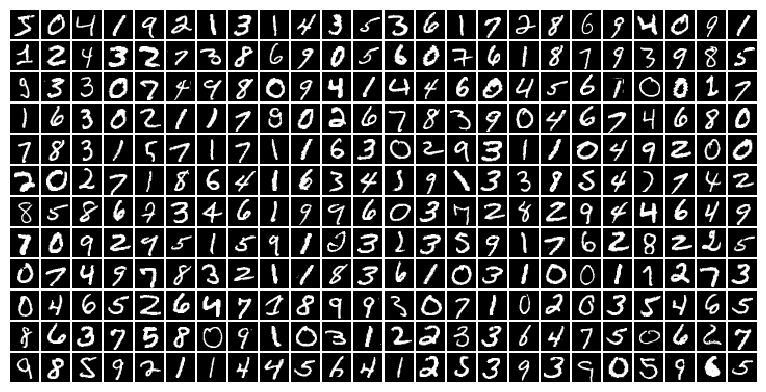

In [49]:
from mnists import MNIST

mnist = MNIST()
digits = mnist.train_images()
digits = digits[: 12 * 24]
digits = digits.reshape(-1, 24, 28, 28)
tiles(digits)

In [50]:
# Training set
X_train = mnist.train_images().astype(np.float32) / 255.0
X_train = X_train.reshape(-1, 28 * 28)
np.random.shuffle(X_train)

size = 60_000
X_train = X_train[:size, ...]

# Test set
X_test = mnist.test_images().astype(np.float32) / 255.0
X_test = X_test.reshape(-1, 28 * 28)

Define autoencoder

In [51]:
autoencoder = nn.Sequential(
    nn.Linear(vsize=784, hsize=256, init_method="Xavier"),
    nn.Sigmoid(),
    nn.Linear(vsize=256, hsize=128, init_method="Xavier"),
    nn.Sigmoid(),
    nn.Linear(vsize=128, hsize=64, init_method="Xavier"),
    nn.Sigmoid(),
    nn.Linear(vsize=64, hsize=10, init_method="Xavier"),
    nn.Linear(vsize=10, hsize=64, init_method="Xavier"),
    nn.Sigmoid(),
    nn.Linear(vsize=64, hsize=128, init_method="Xavier"),
    nn.Sigmoid(),
    nn.Linear(vsize=128, hsize=256, init_method="Xavier"),
    nn.Sigmoid(),
    nn.Linear(vsize=256, hsize=784, init_method="Xavier"),
)

Specify loss function

In [52]:
def cross_entropy(targets: NDArray, logits: NDArray) -> float:
    batch_size = targets.shape[0]
    σ = sigmoid(logits)
    return -1 / batch_size * np.sum(targets * np.log(σ) + (1 - targets) * np.log(1 - σ))

Run training

In [53]:
from math import ceil
from tqdm import trange

batch_size = 128
num_epochs = 50

autoencoder.reset()

optimizer = optim.SGD(
    autoencoder.parameters(),
    lr=0.01,
    momentum=0.95,
    nesterov=True,
)

for epoch in (pbar := trange(num_epochs)):
    dataloader = chunks(X_train, size=batch_size)
    total = ceil(len(X_train) / batch_size)

    # Training phase
    for X_batch in dataloader:
        # Forward pass
        logits = autoencoder.forward(X_batch, training=True)

        # Compute gradient of the loss function w.r.t. the outputs of the network, assuming that the
        # loss function is the *pixelwise binary cross entropy*.
        grad_y = 1 / len(X_batch) * (sigmoid(logits) - X_batch)

        # Backward pass
        autoencoder.backward(grad_y)

        # Update parameters
        optimizer.apply(autoencoder.gradients())

    # Validation phase
    valid_loss = cross_entropy(X_test, autoencoder.forward(X_test, training=False))

    # Log progress
    pbar.set_description(f"Epoch {epoch+1:>3d} | Valid. Loss {valid_loss:>2.2f} |")

Epoch  50 | Valid. Loss 79.80 |: 100%|██████████| 50/50 [02:08<00:00,  2.57s/it] 


Show reconstructions

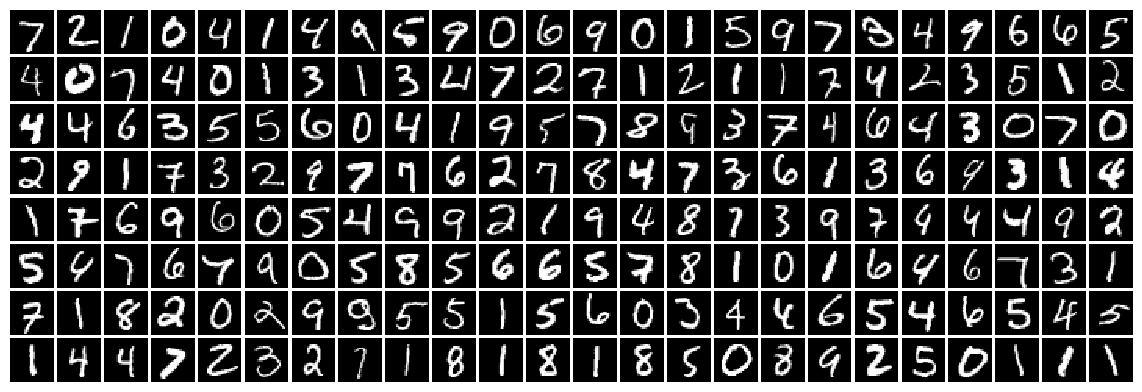

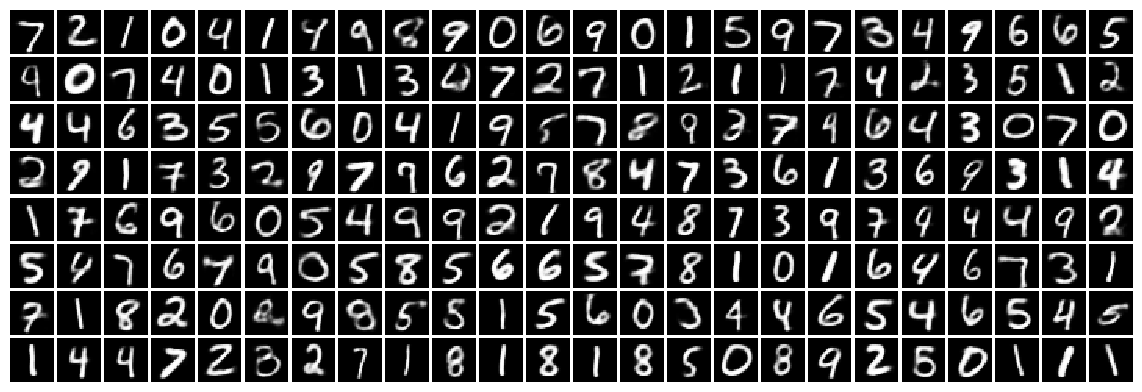

In [54]:
tiles(X_test[: 8 * 24, ...].reshape(8, 24, 28, 28))
reconstructions = autoencoder.forward(X_test[: 8 * 24, ...], training=False)
reconstructions = sigmoid(reconstructions)
tiles(reconstructions.reshape(8, 24, 28, 28))